# Homework 10

In this homework, you will train a sentiment classifier on the [SST-2](https://huggingface.co/datasets/sst2) dataset using the pre-trained BERT model. For simplicity, I recommend using the [Hugging Face Transformers library](https://huggingface.co/docs/transformers/index). I've linked to corresponding tutorials below. You're welcome to use a different framework if you prefer.

# Problem 1

1. Fine-tune [DistilBERT](https://huggingface.co/distilbert-base-uncased) from scratch on SST-2 and evaluate the results. You can find a tutorial for loading BERT and fine-tuning [here](https://huggingface.co/docs/transformers/training). In that tutorial, you will need to change the dataset from `"yelp_review_full"` to `"sst2"` and the model from `"bert-base-uncased"` to `"distilbert-base-uncased"`. You'll also need to modify the code since SST-2 is a two-class classification dataset (unlike the Yelp Reviews dataset, which is a five-class classification dataset).
2. Choose a different pre-trained BERT-style model from the [Hugging Face Model Hub](https://huggingface.co/models) and fine-tune it. There are tons of options - part of the homework is navigating the hub to find different models! I recommend picking a model that is smaller than BERT-Base (as DistilBERT is) just to make things computationally cheaper. Is the final validation accuracy higher or lower with this other model?

In [ ]:
!pip install transformers nlp datasets
!pip install -U sentence-transformers -q
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp
import torch
import torch.nn.functional as F
from datasets import load_dataset,concatenate_datasets
from transformers import AutoTokenizer,AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sentence_transformers import SentenceTransformer

In [2]:
ds_original_from_hf = load_dataset("sst2")
train_ds = ds_original_from_hf['train']

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

***Problem 1.1:***

In [3]:
def tokenize(batch):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

def forward_pass_with_loss_and_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items() 
                if k in tokenizer.model_input_names }
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none' )
        
    return {'loss': loss.cpu().numpy(), 
            'predicted_label': pred_label.cpu().numpy() }

def label_int2str(row):
    return ds_original_from_hf['train'].features['label'].int2str(row)

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
  
def plot_confusion_matrix2(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
model_name='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ds_pretrained_features_encoded = ds_original_from_hf.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = len(ds_original_from_hf['train'].features['label'].names)
label_names = ds_original_from_hf['train'].features['label'].names
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels ).to(device) )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

*** For fine-tuning DistilBER from scratch: I could only run one epoch because the GPU did not stay connected if I ran more than one.***

In [6]:
batch_size = 12

logging_steps = len(ds_pretrained_features_encoded['train']) // batch_size
model_name_ft = f"{model_name}-finetune-sst2"
training_args = TrainingArguments(output_dir = model_name_ft, 
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  optim="adamw_torch"
                                  )
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset = ds_pretrained_features_encoded['train'],
                  eval_dataset = ds_pretrained_features_encoded["validation"],
                  tokenizer = tokenizer
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.240800,0.345153,0.897936,0.897873


TrainOutput(global_step=5613, training_loss=0.24082379685819372, metrics={'train_runtime': 513.9416, 'train_samples_per_second': 131.044, 'train_steps_per_second': 10.921, 'total_flos': 1150043146323192.0, 'train_loss': 0.24082379685819372, 'epoch': 1.0})

In [7]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])
preds_output.metrics

{'test_loss': 0.3451531231403351,
 'test_accuracy': 0.8979357798165137,
 'test_f1': 0.8978732851825808,
 'test_runtime': 1.626,
 'test_samples_per_second': 536.292,
 'test_steps_per_second': 44.896}

In [8]:
# Convert our dataset back to PyTorch tensors
ds_pretrained_features_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_pretrained_features_encoded["validation"] = ds_pretrained_features_encoded["validation"].map(
    forward_pass_with_loss_and_label, batched=True, batch_size=16)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [9]:
ds_pretrained_features_encoded.set_format("pandas")
cols = ['sentence', "label", "predicted_label", "loss"]
df_test = ds_pretrained_features_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))
df_test.sort_values('loss', ascending=False ).head(10)

,sentence,label,predicted_label,loss
791,it 's somewhat clumsy and too lethargically pa...,negative,positive,6.816956
771,"very special effects , brilliantly bold colors...",negative,positive,5.844652
95,this riveting world war ii moral suspense stor...,negative,positive,5.839524
519,moretti 's compelling anatomy of grief and the...,negative,positive,5.760512
646,"the longer the movie goes , the worse it gets ...",negative,positive,5.470724
544,although huppert 's intensity and focus has a ...,negative,positive,5.444728
112,hilariously inept and ridiculous .,positive,negative,5.323246
121,it seems to me the film is about the art of ri...,negative,positive,5.301600
501,harrison 's flowers puts its heart in the righ...,positive,negative,5.150640
695,"sit through this one , and you wo n't need a m...",negative,positive,5.118460


In [10]:
df_test.sort_values('loss', ascending=True ).head(10)

,sentence,label,predicted_label,loss
0,it 's a charming and often affecting journey .,positive,positive,0.000654
396,"a very well-made , funny and entertaining pict...",positive,positive,0.000656
492,an exquisitely crafted and acted tale .,positive,positive,0.000662
311,"a warm , funny , engaging film .",positive,positive,0.000662
67,"a fast , funny , highly enjoyable movie .",positive,positive,0.000668
815,a delightful coming-of-age story .,positive,positive,0.000674
32,"a gorgeous , witty , seductive movie .",positive,positive,0.000683
817,a strangely compelling and brilliantly acted p...,positive,positive,0.000687
799,"a tender , witty , captivating film about frie...",positive,positive,0.000713
303,"entertains by providing good , lively company .",positive,positive,0.000713


***Problem 1.2***

In [11]:
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ds_pretrained_features_encoded = ds_original_from_hf.map(tokenize, batched=True, batch_size=None)

model = AutoModel.from_pretrained(model_name).to(device)

model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels ).to(device) )

model_name_ft = f"{model_name}-finetune-sst2"
training_args = TrainingArguments(output_dir = model_name_ft, 
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  optim="adamw_torch"
                                  )
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset = ds_pretrained_features_encoded['train'],
                  eval_dataset = ds_pretrained_features_encoded["validation"],
                  tokenizer = tokenizer
                  )
trainer.train()

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.459600,0.471501,0.792431,0.792219
2,0.339800,0.486617,0.803899,0.803754
3,0.308100,0.491915,0.806193,0.805859


TrainOutput(global_step=16839, training_loss=0.3691669616197151, metrics={'train_runtime': 213.4353, 'train_samples_per_second': 946.643, 'train_steps_per_second': 78.895, 'total_flos': 33089988804840.0, 'train_loss': 0.3691669616197151, 'epoch': 3.0})

In [12]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])
preds_output.metrics

{'test_loss': 0.49191492795944214,
 'test_accuracy': 0.8061926605504587,
 'test_f1': 0.8058591528344803,
 'test_runtime': 0.3882,
 'test_samples_per_second': 2246.168,
 'test_steps_per_second': 188.039}

In [13]:
ds_pretrained_features_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_pretrained_features_encoded["validation"] = ds_pretrained_features_encoded["validation"].map(
    forward_pass_with_loss_and_label, batched=True, batch_size=16)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [14]:
ds_pretrained_features_encoded.set_format("pandas")
cols = ['sentence', "label", "predicted_label", "loss"]
df_test = ds_pretrained_features_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))
df_test.sort_values('loss', ascending=False ).head(10)

,sentence,label,predicted_label,loss
862,"it 's inoffensive , cheerful , built to inspir...",negative,positive,4.386298
382,a great ensemble cast ca n't lift this heartfe...,negative,positive,4.288736
135,pumpkin means to be an outrageous dark satire ...,negative,positive,4.249905
544,although huppert 's intensity and focus has a ...,negative,positive,4.236224
405,"outer-space buffs might love this film , but o...",negative,positive,4.152453
736,american chai encourages rueful laughter at st...,negative,positive,4.022875
292,the story and the friendship proceeds in such ...,negative,positive,4.007323
70,"for all its impressive craftsmanship , and des...",negative,positive,3.947112
513,care deftly captures the wonder and menace of ...,negative,positive,3.939135
575,( director ) o'fallon manages to put some love...,negative,positive,3.928218


In [15]:
df_test.sort_values('loss', ascending=True ).head(10)

,sentence,label,predicted_label,loss
71,exquisitely nuanced in mood tics and dialogue ...,positive,positive,0.010804
457,it inspires a continuing and deeply satisfying...,positive,positive,0.010893
492,an exquisitely crafted and acted tale .,positive,positive,0.010928
383,a warm but realistic meditation on friendship ...,positive,positive,0.010967
0,it 's a charming and often affecting journey .,positive,positive,0.010989
386,it 's a remarkably solid and subtly satirical ...,positive,positive,0.011024
625,for the most part stevens glides through on so...,positive,positive,0.011057
603,first-time writer-director serry shows a remar...,positive,positive,0.011063
484,"dazzling in its complexity , disturbing for it...",positive,positive,0.011142
15,"a gorgeous , high-spirited musical from india ...",positive,positive,0.011143


The final accuracy is lower for the tiny BERT model than the DistilBERT model. The accuracy after one epoch for DistilBERT is 89.79%, and the accuracy after three epochs is 80.62%. However, the tiny BERT model was a lot faster to run.

# Problem 2

Instead of fine-tuning the full model on a target dataset, it's also possible to use the output representations from a BERT-style model as input to a linear classifier and *only* train the classifier (leaving the rest of the pre-trained parameters fixed). You can do this easily using the [`sentence-transformers`](https://www.sbert.net/) library. Using `sentence-tranformers` gives you back a fixed-length representation of a given text sequence. To achieve this, you need to 
1. Pick a pre-trained sentence Transformer.
2. Load the SST-2 dataset and feed the text from each example into the model.
3. Train a linear classifier on the representations.
4. Evaluate performance on the validation set.

For the second step, you can learn more about how to use Hugging Face datasets [here](https://huggingface.co/docs/datasets/index). For the third and fourth step, you can do this directly in PyTorch, or you can just collect the learned representations and use them as feature vectors to train a linear classifier in any other library (e.g. [scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html).

After you complete the above steps, report whether the accuracy on the validation set is higher or lower using a fixed sentence Transformer.

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentenceTransformer('all-MiniLM-L6-v2',device)

In [25]:
df = ds_original_from_hf['train'].to_pandas()
encodings = model.encode(df['sentence'].to_list(),show_progress_bar=True)
ser = pd.Series(encodings.tolist())
df = pd.concat((df, ser.rename('embeddings')), axis=1)
X = np.array(df['embeddings'].to_list())
y = np.array(df['label'].to_list())

df = ds_original_from_hf['validation'].to_pandas()
encodings = model.encode(df['sentence'].to_list(),show_progress_bar=True)
ser = pd.Series(encodings.tolist())
df = pd.concat((df, ser.rename('embeddings')), axis=1)
X_valid = np.array(df['embeddings'].to_list())
y_valid = np.array(df['label'].to_list())

LR = LogisticRegression(solver='lbfgs', max_iter=1000)
LR.fit(X,y)

predicted = LR.predict(X_valid)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_valid, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_valid, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_valid, predicted))

Batches:   0%|          | 0/2105 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.8142201834862385
Logistic Regression Precision: 0.8204545454545454
Logistic Regression Recall: 0.8130630630630631


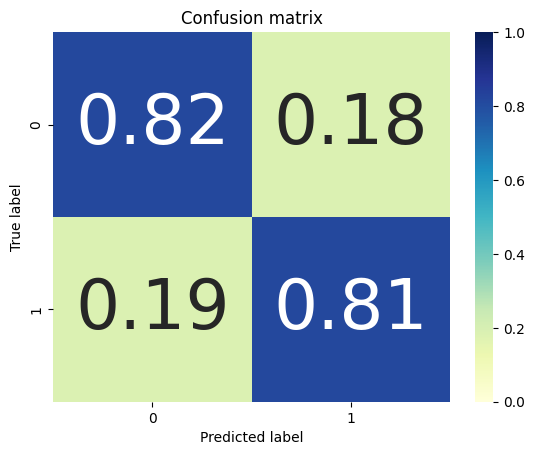

In [26]:
label_names = ds_original_from_hf['train'].features['label'].names
cm = confusion_matrix(y_valid, predicted)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix2(cm_norm, classes = LR.classes_, title='Confusion matrix')

The accuray for the fixed Sentence Transformer is lower than DistilBERT. The fixed Sentence Transformer has an accuracy of 81.41%, and DistilBERT has an accuracy of 89.79%.

***Another way to extract Last Hidden State and use in classifier***

In [19]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

In [20]:
def get_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names }
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy() }

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Xtrain_shape : (67349, 768), X_valid_shape: (872, 768)
Logistic Regression_Score 0.8302752293577982


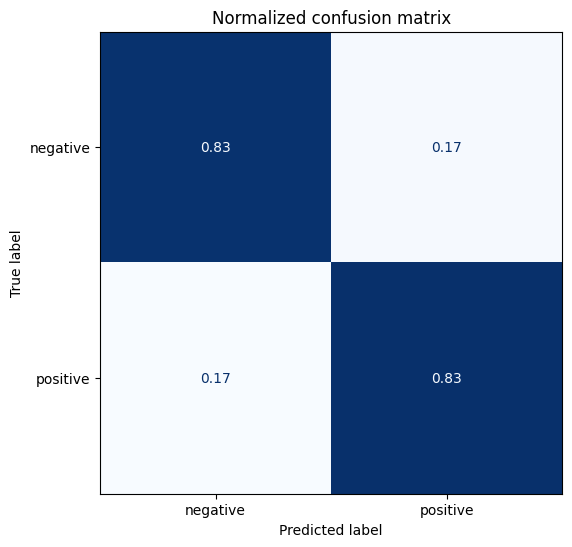

In [21]:
ds_pretrained_features_encoded.set_format('torch', columns = ["input_ids", "attention_mask", "label"] )
pretrained_hidden_states = ds_pretrained_features_encoded.map(get_hidden_state, batched=True)
pretrained_hidden_states['train'].column_names

import numpy as np

X_train = np.array(pretrained_hidden_states["train"]["hidden_state"])
X_valid = np.array(pretrained_hidden_states['validation']["hidden_state"])

y_train = np.array(pretrained_hidden_states["train"]["label"])
y_valid = np.array(pretrained_hidden_states["validation"]["label"])
print(f'Xtrain_shape : {X_train.shape}, X_valid_shape: {X_valid.shape}')

from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter = 5000)
lr_clf.fit(X_train, y_train)
print('Logistic Regression_Score',lr_clf.score(X_valid, y_valid))

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, label_names)